In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.chdir('/data7/brandon/research/DA_MVR/sil_consistent_at_inference')
import sys

import torch
from torch.nn import functional as F
from PIL import Image
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.transform import resize
from skimage import img_as_bool
from tqdm import tqdm
import glob
import pprint
import pickle
import copy
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftPhongShader
)

from utils import utils
from deformation.deformation_net import DeformationNetwork
from mesh_refiner import MeshRefiner

In [6]:
DATASET_PATH = "notebooks/test_dataset"
mesh_paths = sorted(glob.glob(os.path.join(DATASET_PATH, "*mesh.obj")))
data_info = []
pred_poses = pickle.load(open("notebooks/test_dataset_cached_pred_poses.p", "rb"))
# todo: add back in last one by adding in cache
for mesh_path in mesh_paths:
    instance_number = int(mesh_path.split('/')[-1][:2])
    instance_img_path = os.path.join(DATASET_PATH, "{:02d}_in.jpg".format(instance_number))
    instance_mask_path = os.path.join(DATASET_PATH, "00{:02d}.png".format(instance_number+1))
    img_name = instance_img_path.split('/')[-1]
    simp_mesh_path = mesh_path.replace(".obj","_simp.obj")
    data_info.append({"mesh": mesh_path, "simp_mesh": simp_mesh_path, "input_img": instance_img_path, "mask": instance_mask_path,
                      "azim": pred_poses[img_name]['azim'], "dist": pred_poses[img_name]['dist'], "elev": pred_poses[img_name]['elev']})

{'azim': 265.2631530761719,
 'dist': 1.2051281929016113,
 'elev': 0.0,
 'input_img': 'notebooks/test_dataset/00_in.jpg',
 'mask': 'notebooks/test_dataset/0001.png',
 'mesh': 'notebooks/test_dataset/00_mesh.obj',
 'simp_mesh': 'notebooks/test_dataset/00_mesh_simp.obj'}


/data7/drone_machinelearning/anaconda3/envs/standard/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


(224, 224, 3)
(224, 224)


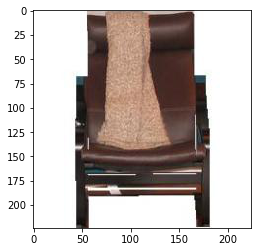

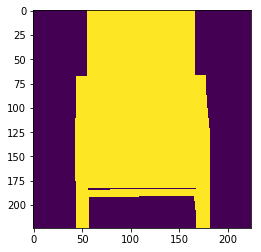

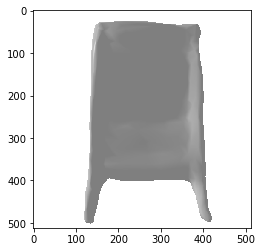

In [7]:
device = torch.device("cuda:7")

for data in data_info[:1]:
    pprint.pprint(data)
    
    # loading in image, mesh, mask, predicted pose data
    input_image = np.asarray(Image.open(data['input_img']).convert('RGB'))
    with torch.no_grad():
        mesh = utils.load_untextured_mesh(data['simp_mesh'], device)
    mask = Image.open(data['mask']).resize((224,224))
    mask = np.asarray(mask)
    mask = (mask[:,:,3]> 0)
    pred_dist = data['dist']
    pred_elev = data['elev']
    pred_azim = data['azim']
    
    # rendering mesh at predicted pose
    R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim) 
    mesh_rendered_at_pred_pose = utils.render_mesh(mesh, R, T, device)
    
    # visualizing
    print(input_image.shape)
    print(mask.shape)
    plt.imshow(input_image)
    plt.show()
    plt.imshow(mask)
    plt.show()
    plt.imshow(mesh_rendered_at_pred_pose[0, ..., :3].cpu().numpy())
    plt.show()
    
    #break

In [10]:
cfg_yaml_path = "configs/default.yaml"
refiner = MeshRefiner(cfg_yaml_path, device)

refiner.refine_mesh(mesh, input_image, mask, pred_dist, pred_elev, pred_azim)

tensor(2.3702, device='cuda:7', grad_fn=<BinaryCrossEntropyBackward>)
